### CREATE DAILY INPUT FOR THE ML MODEL

Input:
- the measured runoff at the gauging station,
- the catchment area of the gauging station,
- the ERA5 datasets for Potential Evapotranspiration, Temperature and Precipitation.

Output:
    - a .csv file is saved in conda/daily_input folder.

In [2]:
import shapely


In [6]:
from create_daily_csv import interpolate_df,readnetcdf_in_shp,xarray2df,check_data_gap,readnetcdf_in_shp_db
import pandas as pd
import numpy as np
import os
import xarray as xr

In [173]:
import sys, importlib
importlib.reload(sys.modules['create_daily_csv'])

ImportError: cannot import name 'GeoSeries' from 'shapely' (C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\shapely\__init__.py)

In [2]:
shp_catchment_path = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\qgis\final_delineation'
shp_catchment_fileName =shp_catchment_path + r'\candoglia_toce_catchment.shp'

In [3]:
# Runoff
catchment_name = 'CANDOGLIA_TOCE_2000_2019.csv'
fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\data_discharge\\' + catchment_name
#runoff = pd.read_csv(fileName, index_col=2, parse_dates=True)
runoff = pd.read_csv(fileName, delimiter=',', index_col=1
                     , parse_dates=True)

In [4]:
runoff

,id_station,discharge_m3_s,quality
date,,,
2000-01-01,ADO_DSC_ITC1_0014,37.1,no information
2000-01-02,ADO_DSC_ITC1_0014,29.1,no information
2000-01-03,ADO_DSC_ITC1_0014,33.0,no information
2000-01-04,ADO_DSC_ITC1_0014,42.3,no information
2000-01-05,ADO_DSC_ITC1_0014,42.3,no information
...,...,...,...
2019-12-27,ADO_DSC_ITC1_0014,72.8,no information
2019-12-28,ADO_DSC_ITC1_0014,68.5,no information
2019-12-29,ADO_DSC_ITC1_0014,65.6,no information


runoff.index = pd.to_datetime(runoff.Datum, format='%d.%m.%Y')

runoff['discharge_m3_s']=runoff['pretok (m3/s)']

#runoff=runoff.drop(columns='pretok (m3/s)')
runoff=runoff.drop(columns=['Datum','temp. vode (°C)','transport suspendiranega materiala (kg/s)','vsebnost suspendiranega materiala (g/m3)'])

In [5]:
check_data_gap(runoff)
runoff = runoff.reindex(pd.date_range(runoff.index.min() - pd.DateOffset(years=1), runoff.index.max()), fill_value=np.nan)
runoff = runoff.rename(columns={'discharge_m3_s': 'Q'})
#runoff.drop(['id_station','quality'],axis=1,inplace=True)

Date start: 2000-01-01, date end: 2019-12-31
No missing dates


In [7]:
    res=5500
    nc_fileName=  r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\2m_temperature-19790101_20181231-eusalp-qm_era5.nc'
    # Open the netcdf file
    ds = xr.open_dataset(nc_fileName)
    STAT_CODE='ADO_DSC_ITH2_0034'

n of pixels351


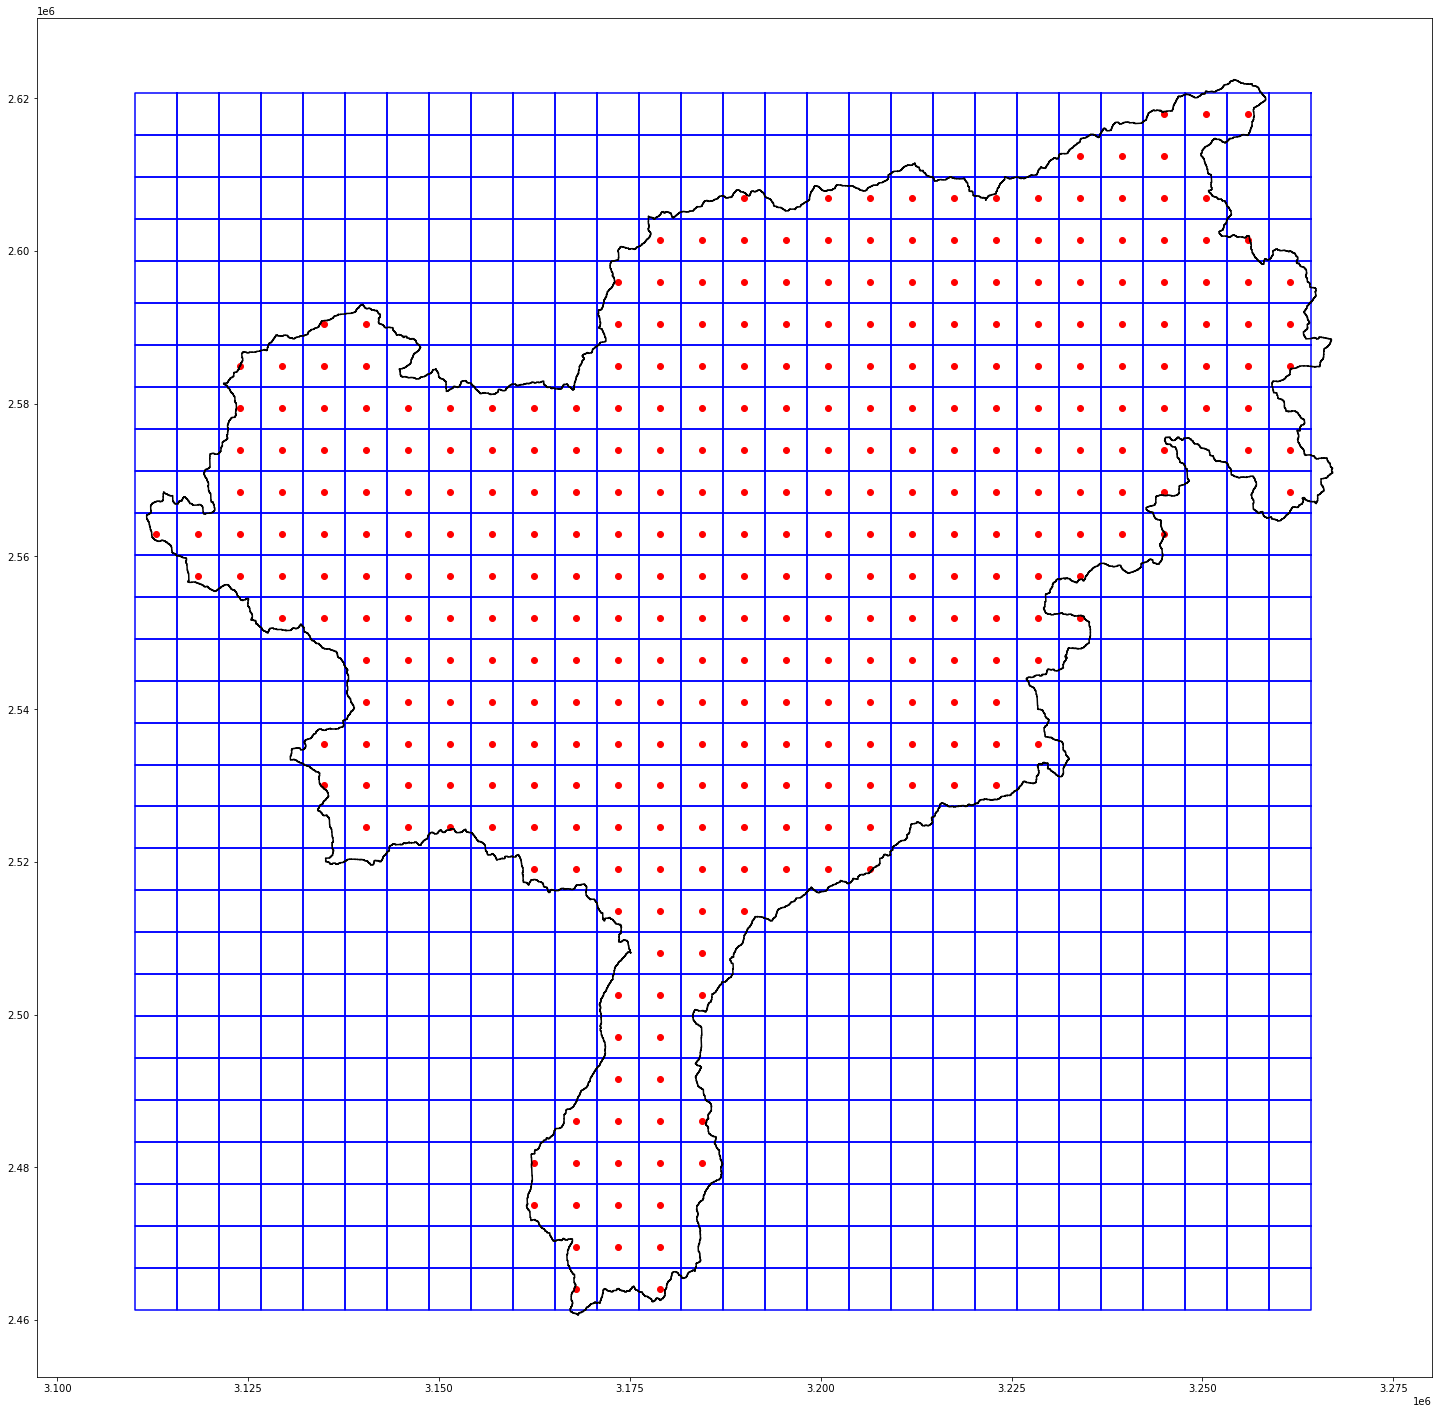

In [8]:
# ERA5 temperature

era5_fileName=  r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\2m_temperature-19790101_20181231-eusalp-qm_era5.nc'

t2m = readnetcdf_in_shp_db(era5_fileName,STAT_CODE,plot=True,res=5500)['t2m']

In [17]:
t2m.to_dataframe().dropna().query('time=="1979-01-01"').t2m

time        y        x      
1979-01-01  2464000  3168000    271.256754
                     3179000    270.305517
            2469500  3168000    270.874015
                     3173500    270.956176
                     3179000    270.083695
                                   ...    
            2612500  3239500    260.942342
                     3245000    260.180484
            2618000  3245000    259.337471
                     3250500    257.347369
                     3256000    255.146206
Name: t2m, Length: 351, dtype: float64

n of pixels75
Date start: 1979-01-01, date end: 2018-12-31
No missing dates


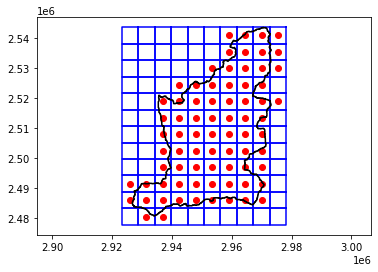

In [6]:
t2m = xarray2df(t2m.resample(time='1d').mean(), 'T','t2m')

check_data_gap(t2m)

In [7]:
t2m

,Tx1y0,Tx2y0,Tx0y1,Tx1y1,Tx2y1,Tx3y1,Tx4y1,Tx5y1,Tx6y1,Tx7y1,...,Tx8y9,Tx9y9,Tx6y10,Tx7y10,Tx8y10,Tx9y10,Tx6y11,Tx7y11,Tx8y11,Tx9y11
time,,,,,,,,,,,,,,,,,,,,,
1979-01-01,262.910008,266.522871,252.899861,261.561677,265.545569,268.907330,270.299522,270.538091,269.468983,271.974710,...,263.650022,266.008960,257.310702,258.378406,260.586447,263.206979,257.844099,257.609792,258.657027,261.783548
1979-01-02,251.322566,257.321796,239.181288,248.111182,256.529939,259.277913,261.362784,262.354657,260.486494,263.011944,...,255.771174,258.960664,248.400247,249.309736,251.429530,255.575498,248.471712,249.085217,249.469994,253.965380
1979-01-03,252.655902,258.621366,240.807567,249.852175,257.252173,261.165574,262.757856,263.506730,261.699091,264.144288,...,256.753473,259.137966,249.427912,250.315948,252.572664,256.598880,248.965587,248.867550,250.560398,254.480227
1979-01-04,255.644058,259.961687,243.126563,252.977407,259.030603,262.183129,263.210312,263.585592,262.441054,264.319801,...,257.800634,260.473699,251.110930,251.680498,254.011703,257.494792,252.114737,250.913442,252.068326,256.037305
1979-01-05,256.089912,260.735810,243.867795,253.747914,259.447006,262.965152,264.244323,264.746995,263.179736,265.990432,...,259.989821,262.300821,252.904398,254.258023,256.909234,259.714127,254.114621,253.748774,254.838208,258.117642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,268.446868,270.789301,261.786414,267.393029,269.569939,272.709129,272.991344,272.464991,270.967427,273.470660,...,267.988816,270.108452,264.079291,264.867636,266.408451,267.601332,265.273487,264.230339,264.507171,266.667468
2018-12-28,269.690181,272.302690,263.661021,269.029303,270.949566,274.333576,274.372766,273.720691,272.268617,274.782723,...,269.144235,271.508565,265.046886,265.958064,267.851161,268.968036,266.633863,265.476345,265.948870,268.526482
2018-12-29,269.058363,271.754627,262.534459,268.295353,270.568600,274.190718,274.397279,274.058392,272.728693,275.544232,...,269.199883,271.516542,265.002552,265.880488,267.700732,268.819915,266.226861,265.192971,265.452405,268.063641


n of pixels45
Date start: 1979-01-01, date end: 2018-12-31
No missing dates


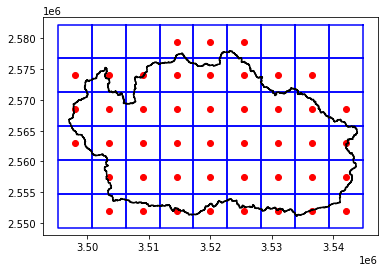

In [13]:
# ERA5 evapotranspiration
era5_fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\potential_evapotranspiration-19790101_20181231-eusalp-qm_era5.nc'

pet = readnetcdf_in_shp(era5_fileName, shp_catchment_fileName,plot=True)['pet']
pet = xarray2df(pet.resample(time='1d').sum(skipna=False), 'E','pet')

check_data_gap(pet)

n of pixels45
Date start: 1979-01-01, date end: 2018-12-31
No missing dates


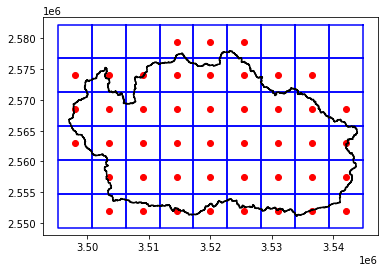

In [14]:
# ERA5 total precipitation
era5_fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\total_precipitation-19790101_20181231-eusalp-qm_era5.nc'

tp = readnetcdf_in_shp(era5_fileName, shp_catchment_fileName,plot=True)['tp']
tp = xarray2df(tp.resample(time='1d').sum(skipna=False), 'P','tp')

check_data_gap(tp)

In [15]:
# Concatenate and save
daily_input = pd.concat([runoff, t2m, tp, pet], axis=1, join='inner')
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'+catchment_name
#save into a csv file.
# if file does not exist write header 
if not os.path.isfile(path):
   daily_input.to_csv(path)
else: # else print the problem
   print('file already exists')

In [92]:
import psycopg2
import shapely.wkt as wkt
import shapely.wkb as wkb
from geopandas import GeoSeries


from shapely.geometry import Point, Polygon
import xarray as xr

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
plot=True

In [171]:
    res=5500
    nc_fileName=  r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\2m_temperature-19790101_20181231-eusalp-qm_era5.nc'
    # Open the netcdf file
    ds = xr.open_dataset(nc_fileName)

In [94]:
    conn = psycopg2.connect(host="10.8.244.31",
                       database="climate_data",
                       user="ado_admin",
                       password="oda347hydro",
                       port=5432)
    cur = conn.cursor()
    
    # get the metadata
    query = f"""
            SELECT "geom"  FROM "hydrology"."ADO_BASINS" WHERE "id_station" = '{STAT_CODE}'    
            """
    df = pd.read_sql_query(query, conn)


In [97]:
shp=GeoSeries(wkb.loads(df.geom[0], hex=True))

In [71]:
shp=shp.set_crs("EPSG:4326")

In [72]:
    shp_reproj = shp.to_crs('+proj=lcc +lat_1=50 +lat_2=50 +lat_0=50 +lon_0=8 +x_0=2937018.5829291 +y_0=2937031.41074803 +a=6371229 +b=6371229')
    

In [73]:
shp_reproj

0    MULTIPOLYGON (((2769914.794 2721853.834, 27699...
dtype: geometry

n of pixels2352


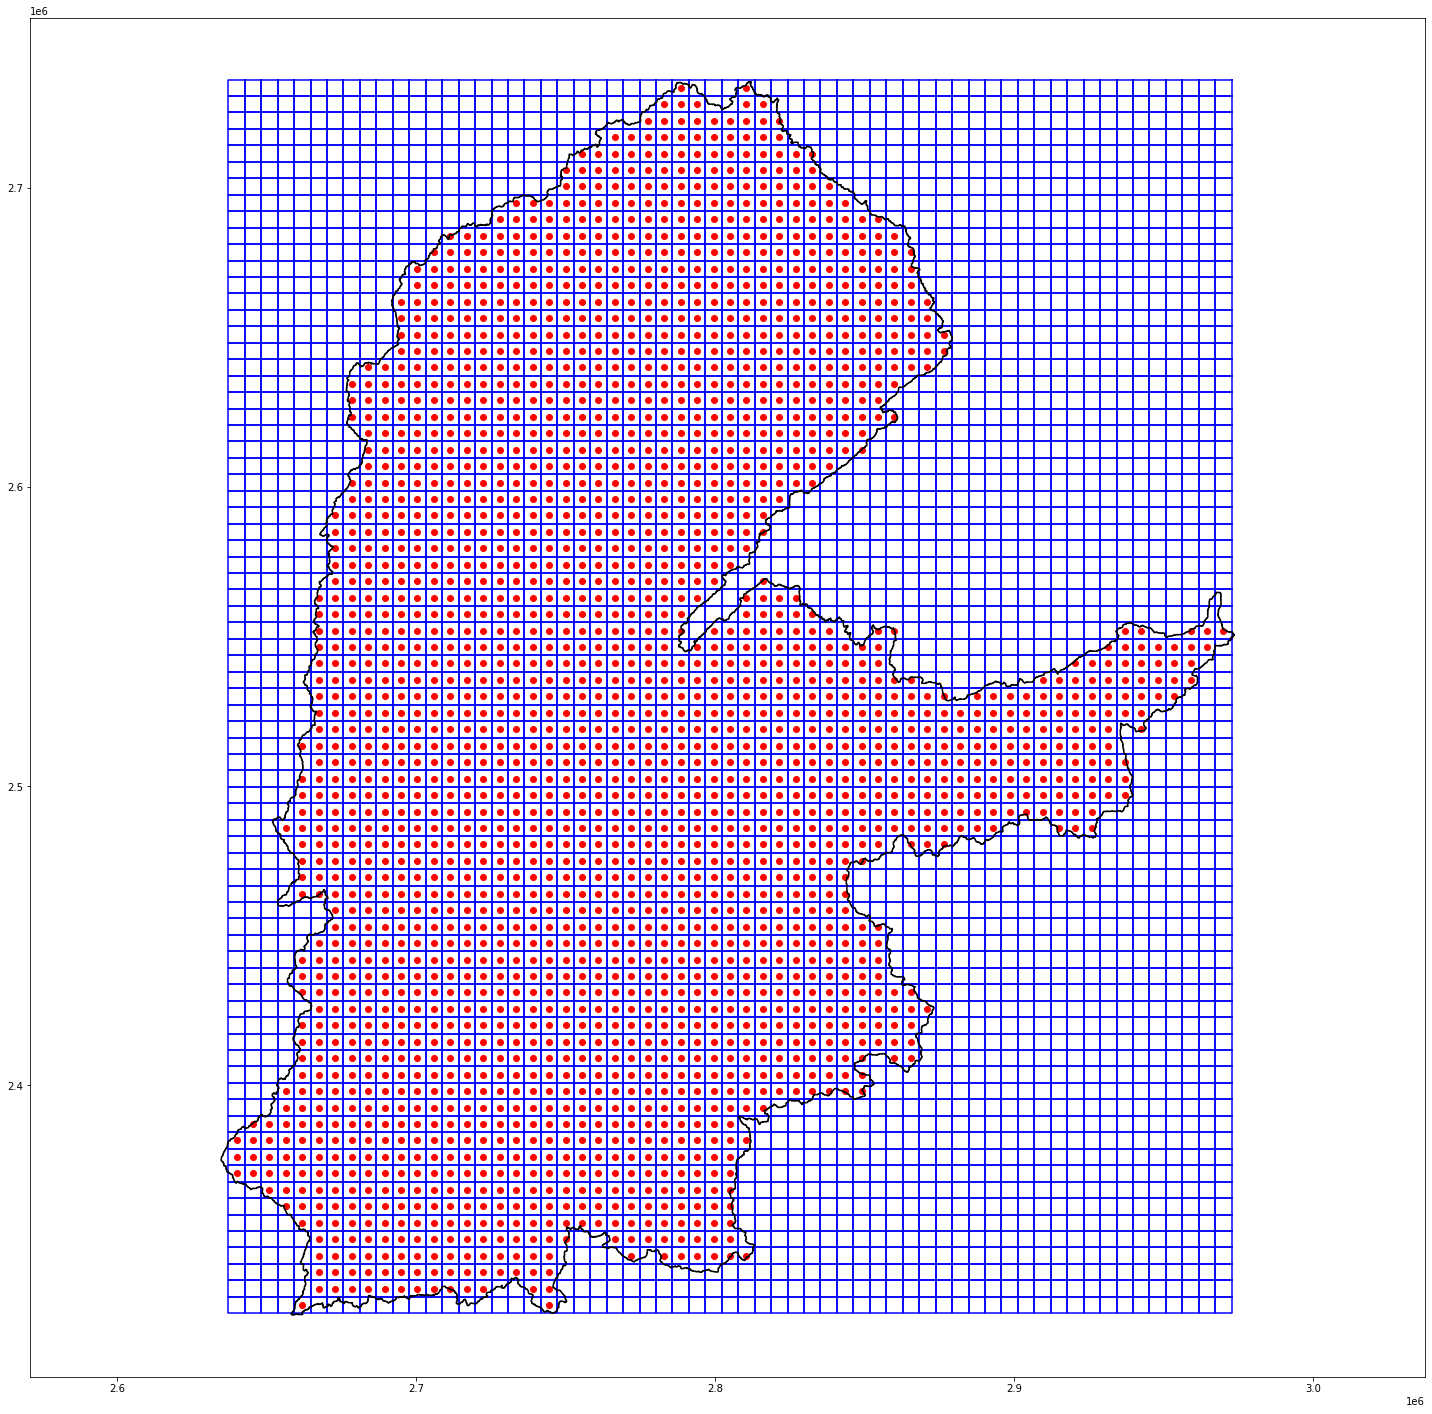

In [158]:
    # Crop ds with the shapefile bounding box (bb)
    bb = shp_reproj.bounds.iloc[0]
    ds = ds.sel(x=slice(bb['minx']-res, bb['maxx']+res), 
                y=slice(bb['miny']-res, bb['maxy']+res))
    
    
    #0000 Mask all the points in ds where the grid box do not intersect or is in the shapefile
    for i in ds.x.values:
        for j in ds.y.values:
            gridbox = Point(i, j)#.buffer(res/2, cap_style=3)
            if not (gridbox.intersects(shp_reproj.loc[0])):
                for k in ds.data_vars.keys():
                    if not (k =='Lambert_Conformal'):
                        ds[k].loc[dict(x=i, y=j)] = np.nan
    ds = ds.dropna(dim='x', how='all')
    ds = ds.dropna(dim='y', how='all')
    counter=0                    
    # Plot the era5 gridbox and the shapefile if plot=True
    if plot:
        plt.figure(figsize=(25,25))
        for x in ds.x.values:
            for y in ds.y.values:
                gridbox = Point(x, y).buffer(res / 2, cap_style=3)
                gridbox_x, gridbox_y = gridbox.exterior.xy
                plt.plot(gridbox_x, gridbox_y, color='blue')
                for k in ds.data_vars.keys():
                    if (k !='Lambert_Conformal'):
                        if not(ds[k].loc[dict(x=x, y=y)].isnull().all()):
                            plt.plot(x, y, marker='o', color='red')
                            counter=counter+1
        
        coords=[p.exterior.xy for p in shp_reproj.loc[0]]
        shp_x=coords[0][0]
        shp_y=coords[0][1]
        #shp_x, shp_y = *shp_reproj.loc[0].exterior.xy
        plt.plot(shp_x, shp_y, color='black')
        plt.axis('equal')                        
    print(f'n of pixels{counter}')

In [143]:
coords=[p.exterior.xy for p in shp_reproj.loc[0]]

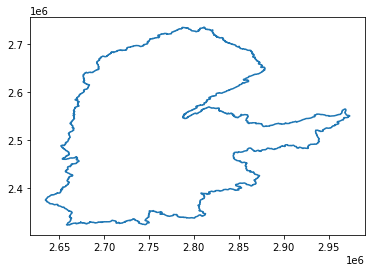

In [154]:
plt.plot(x,y)

In [153]:
x=coords[0][0]
y=coords[0][1]